Progress Report for Kortright Bioretention Tracer Test modelling


#Step one - work out the flows. To do this, I just optimized the infiltration rate - all other values are not calibrated

In [2]:
#Import packages
import time
import pandas as pd
import numpy as np
from BCBlues import BCBlues
#from Hydro_veg import Hydro_veg
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from hydroeval import *
from scipy.optimize import minimize
import math
#plt.style.use("ggplot")
#from data_1d import makeic

In [10]:
#Load the hydrological model outputs from a pickle file
outpath ='D:/OneDrive - University of Toronto/University/_Active Projects/Bioretention Blues Model/Model/Pickles/Flow_time_tracertest_BC1.pkl'
timeseries = pd.read_excel('timeseries_tracertest_Kortright.xlsx')
res_time = pd.read_pickle(outpath)
#res_time.info()

In [9]:
#We can optimize the flow module using an estimate of model accuracy - nash-sutcliffe coefficient or other (kling-gupta)
#Comparing the observed flows to the estimated flows
import pdb
#Load the model parameterization files
params = pd.read_excel('params_BC_1.xlsx',index_col = 0) 
locsumm = pd.read_excel('Kortright_BC_1.xlsx',index_col = 0)
locsumm.iloc[:,slice(0,14)] = locsumm.astype('float') #Convert any ints to floats 
chemsumm = pd.read_excel('Kortright_CHEMSUMM.xlsx',index_col = 0)
timeseries = pd.read_excel('timeseries_tracertest_Kortright.xlsx') #Runs for 3.5 hrs before the model starts
#Then, initialize the rest of the model parameters
dt = timeseries.time[1] - timeseries.time[0]#Define the timestep    
numc = np.array(np.concatenate([locsumm.index[0:2].values]),dtype = 'str') #Change to 1 for pure advection testing of water compartment
shiftdist = 0 #~length of time that it takes to get through the pipe!
#Now we define the objective function - we want a minimization problem with the only input Kf
#(in this case we are doing univariate optimization)
def optBC_flow(Kf):
    #pdb.set_trace()
    params.loc['Kf','val'] = Kf #Update the value of Kf for each time step
    test = BCBlues(locsumm,chemsumm,params,timeseries,9)
    res_time = test.flow_time(locsumm,params,numc,timeseries)
    timeseries.loc[:,'Q_drainout']= np.array(res_time.loc[(slice(None),'drain'),'Q_out'])
    timeseries.loc[:,'Q_drainout'] = timeseries.loc[:,'Q_drainout'].shift(shiftdist)
    timeseries.loc[np.isnan(timeseries.Q_drainout),'Q_drainout'] = 0
    #Kling-Gupta Efficiency (modified Nash-Sutcliffe) can be our measure of model performance
    eff = hydroeval.evaluator(kge, np.array(timeseries.loc[timeseries.time>0,'Q_drainout']),\
                          np.array(timeseries.loc[timeseries.time>0,'Qout (measured)']))
    #An efficiency of 1 is ideal, therefore we want to see how far it is from 1
    obj = 1-eff[0] 
    return obj

Kf0 = 0.4 #Define initial value of Kf
#Now, we use the scipy minimize function to optimize. 
#For now, using the nelder-mead parameterization as it doesn't take too long
res = minimize(optBC_flow,Kf0,method='nelder-mead',options={'xtol': 1e-5, 'disp': True})
res

KeyboardInterrupt: 

So this gives us a value for the infiltration rate of 28 cm/hr - which fits into what sylvie found of an infiltration rate of between ~3.5 - 68 cm/hr during the drawdown test.

In [11]:
#Put together the hydrographs for each of the flows
dt = timeseries.time[1] - timeseries.time[0]
hgraphs = timeseries.iloc[:,slice(0,3)].copy(deep=True)
hgraphs.loc[:,'Q_in'] = np.array(res_time.loc[(slice(None),'pond'),'Q_in']) #Includes rain rate
hgraphs.loc[:,'Q_drainout']= np.array(res_time.loc[(slice(None),'drain'),'Q_out'])
hgraphs.loc[:,'Q_drainexf']= np.array(res_time.loc[(slice(None),'drain'),'Q_exf'])
hgraphs.loc[:,'Q_draincap']= np.array(res_time.loc[(slice(None),'drain'),'Q_towater'])
hgraphs.loc[:,'Q_pondwater']= np.array(res_time.loc[(slice(None),'pond'),'Q_towater'])
hgraphs.loc[:,'Q_weir']= np.array(res_time.loc[(slice(None),'pond'),'Q_out'])
hgraphs.loc[:,'Q_pondexf']= np.array(res_time.loc[(slice(None),'pond'),'Q_exf'])
hgraphs.loc[:,'Q_waterdrain']= np.array(res_time.loc[(slice(None),'water'),'Q_todrain'])
hgraphs.loc[:,'Q_et']= np.array(res_time.loc[(slice(None),'water'),'QET'])
hgraphs.loc[:,'V_pond']= np.array(res_time.loc[(slice(None),'pond'),'V'])
hgraphs.loc[:,'V_water']= np.array(res_time.loc[(slice(None),'water'),'V'])
hgraphs.loc[:,'V_drain_pores']= np.array(res_time.loc[(slice(None),'drain_pores'),'V'])
#Storage
hgraphs.loc[:,'dV_pond'] = hgraphs.V_pond - hgraphs.V_pond.shift(1)
hgraphs.loc[:,'dV_water'] = hgraphs.V_water - hgraphs.V_water.shift(1)
hgraphs.loc[:,'dV_drain'] = hgraphs.V_drain_pores - hgraphs.V_drain_pores.shift(1)
#Water Mass Balance - if needed
hgraphs.loc[:,'mbal_pond'] = hgraphs.dV_pond - dt*(hgraphs.Q_in - hgraphs.Q_pondwater-hgraphs.Q_weir-\
                                                     hgraphs.Q_pondexf)
hgraphs.loc[:,'mbal_water'] = hgraphs.dV_water - dt*(hgraphs.Q_pondwater+hgraphs.Q_draincap-\
                                                     hgraphs.Q_waterdrain-hgraphs.Q_et)
hgraphs.loc[:,'mbal_drain'] = hgraphs.dV_drain - dt*(hgraphs.Q_waterdrain-hgraphs.Q_draincap-\
                                                     hgraphs.Q_drainexf-hgraphs.Q_drainout)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


array([[0.74841837],
       [0.8234605 ],
       [0.94990032],
       [1.17209633]])

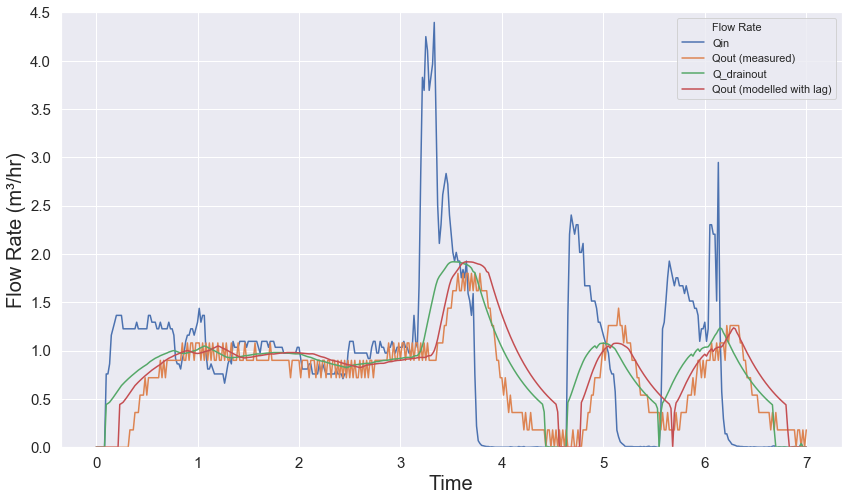

In [26]:
#Now lets plot each of the flows against time
pltdata = hgraphs.loc[hgraphs.time>=0,['time','Qin','Qout (measured)','Q_drainout']] #hgraphs.loc[hgraphs.time>=0,slice('time','Q_waterdrain')]# #after the burn-in period 
pltdata.loc[:,'Qout (modelled with lag)'] = pltdata.Q_drainout.shift(8)
pltdata.loc[np.isnan(pltdata.loc[:,'Qout (modelled with lag)']),'Qout (modelled with lag)'] = 0
eff = hydroeval.evaluator(kge, np.array(pltdata.loc[:,'Q_drainout']),\
                          np.array(pltdata.loc[:,'Qout (measured)']))
pltdata = pltdata.melt('time',var_name = 'Flow Rate',value_name = 'flowrate') #melt the dataframe so that hue will work
ylim = [0, 4.5]
ylabel = 'Flow Rate (m³/hr)'
xlabel = 'Time'
#pltdata = res_time #All times at once
fig = plt.figure(figsize=(14,8))
ax = sns.lineplot(x = pltdata.time, y = 'flowrate', hue = 'Flow Rate',data = pltdata)
ax.set_ylim(ylim)
ax.set_ylabel(ylabel, fontsize=20)
ax.set_xlabel(xlabel, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('20191126Flows.eps',format = 'eps', dpi=400, transparent=True)
eff

So, we can see that the flows have a pretty good agreement, with a Kling-Gupta efficiency of 0.75. Adding the delay (in green) didn't really improve things that much - I think to make this effective (if we want to) we will need the actual pipe specifications, as the time delay will vary with the  velocity (see the beginning of the system vs the peaks)

Now, lets look at the bromide tracer to get an estimate of the dispersivity of the cell. Running the full model with the above we can see what our peaks look like:

D:\Users\Tim Rodgers\Documents\GitHub\BioretentionBlues\Subsurface_Sinks.py:891: RuntimeWarning: invalid value encountered in true_divide
  /np.array(mass_flux.loc[(slice(None),slice(None),0),'N_influent'].groupby(level=0).cumsum())
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


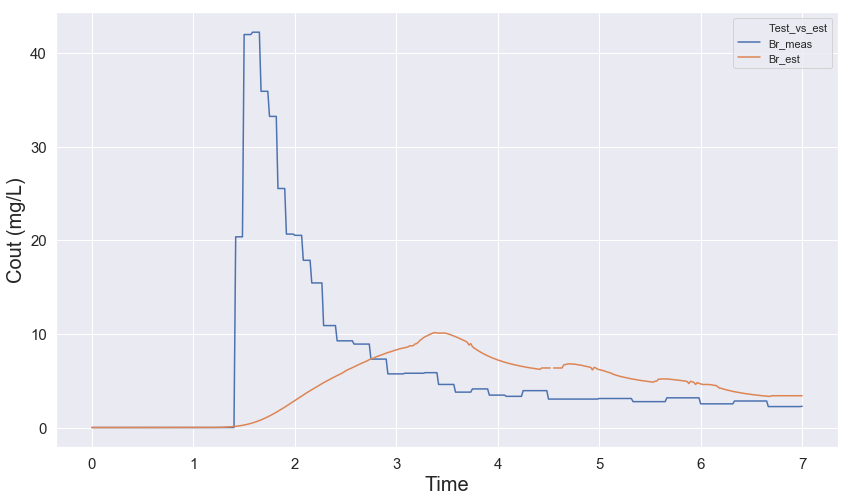

In [10]:
outpath ='D:/OneDrive - University of Toronto/University/_Active Projects/Bioretention Blues Model/Model/Pickles/tracer_outs_BC1.pkl'
res_time = pd.read_pickle(outpath)
from BCBlues import BCBlues
#Now, let's see how the bromide tracer compares with the measured results.
#For this, we need to convert to concentration - C (g/m³)= M/Q*(molar mass)
kortright_bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) #Load the model
mass_flux = kortright_bc.mass_flux(res_time,numc) #Run to get mass flux
numx = mass_flux.index.levels[2][-1]#Final cell
Couts = pd.DataFrame(timeseries.time,index = timeseries[timeseries.time>=0].index)
Couts.loc[:,'Q_out'] = np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])
Couts.loc[:,'Br_meas'] = timeseries[timeseries.time>=0].loc[:,'Bromide_Cout (measured)'] #g/m³
Couts.loc[:,'Br_est'] = np.array(mass_flux.loc[('Bromide',slice(None),numx),'N_effluent'])\
/np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])*np.array(chemsumm.MolMass.Bromide)
Couts[np.isnan(Couts)] = 0
pltdata = Couts[['time','Br_meas','Br_est']]
pltdata = pltdata.melt('time',var_name = 'Test_vs_est',value_name = 'Cout (mg/L)')
ylim = [0, 50]
ylabel = 'Cout (mg/L)'
xlabel = 'Time'
#pltdata = res_time #All times at once
fig = plt.figure(figsize=(14,8))
ax = sns.lineplot(x = pltdata.time, y = 'Cout (mg/L)', hue = 'Test_vs_est',data = pltdata)
#ax.set_ylim(ylim)
ax.set_ylabel(ylabel, fontsize=20)
ax.set_xlabel(xlabel, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

So, you can see that this doesn't work so well (KGE= -0.325). Basically the problem is that despite the flows matching, the HRT in the above system is much too long. From a purely back-of-the envelope perspective, we know that the time it takes to get through the system is ~ 1 hr, and in that time it has to go ~45cm. With an average flow rate of ~1m³/hr this gives us a velocity through the flow paths of ~ 40cm/hr - whereas with the full area 30*0.4 = 12m², v ~ 8 cm/hr
To solve this, reduced the area in line with the observed HRT/theoretical HRT = 0.39 (for bromide tracer).
Running our optimization again gives us a dispersivity coefficient of 0.085 m - close to a theoretical value based on unconsolidated sediments of 0.14 m. Skipping this optimization for now, our final Bromide hydrograph looks like:

D:\Users\Tim Rodgers\Documents\GitHub\BioretentionBlues\Subsurface_Sinks.py:891: RuntimeWarning: invalid value encountered in true_divide
  /np.array(mass_flux.loc[(slice(None),slice(None),0),'N_influent'].groupby(level=0).cumsum())
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


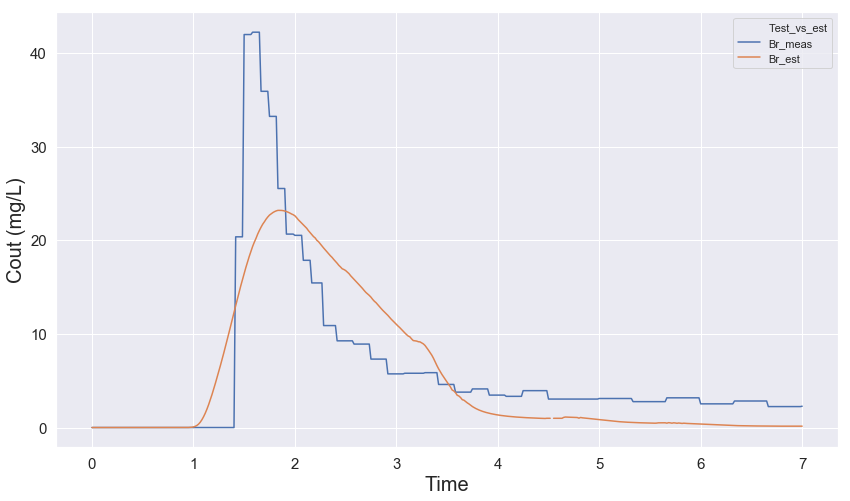

In [12]:
outpath ='D:/OneDrive - University of Toronto/University/_Active Projects/Bioretention Blues Model/Model/Pickles/tracer_outs_opt.pkl'
res_time = pd.read_pickle(outpath)
from BCBlues import BCBlues
#Now, let's see how the bromide tracer compares with the measured results.
#For this, we need to convert to concentration - C (g/m³)= M/Q*(molar mass)
kortright_bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) #Load the model
mass_flux = kortright_bc.mass_flux(res_time,numc) #Run to get mass flux
numx = mass_flux.index.levels[2][-1]#Final cell
Couts = pd.DataFrame(timeseries.time,index = timeseries[timeseries.time>=0].index)
Couts.loc[:,'Q_out'] = np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])
Couts.loc[:,'Br_meas'] = timeseries[timeseries.time>=0].loc[:,'Bromide_Cout (measured)'] #g/m³
Couts.loc[:,'Br_est'] = np.array(mass_flux.loc[('Bromide',slice(None),numx),'N_effluent'])\
/np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])*np.array(chemsumm.MolMass.Bromide)
Couts[np.isnan(Couts)] = 0
pltdata = Couts[['time','Br_meas','Br_est']]
pltdata = pltdata.melt('time',var_name = 'Test_vs_est',value_name = 'Cout (mg/L)')
ylim = [0, 50]
ylabel = 'Cout (mg/L)'
xlabel = 'Time'
#pltdata = res_time #All times at once
fig = plt.figure(figsize=(14,8))
ax = sns.lineplot(x = pltdata.time, y = 'Cout (mg/L)', hue = 'Test_vs_est',data = pltdata)
#ax.set_ylim(ylim)
ax.set_ylabel(ylabel, fontsize=20)
ax.set_xlabel(xlabel, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

So we can see that this is pretty good (KGE - 0.73), although not perfect - peak is lower than it should be, and it drops off faster. This is caused mostly by differing velocities within the system - in order to have the system mass balance work I have made the velocity in each discrete cell linear interpolated between the inlet and the outlet of the soil, so that it changes in the depth direction. Is this a reasonable thing to do, or can you think of a better way to go about it?

D:\Users\Tim Rodgers\Documents\GitHub\BioretentionBlues\Subsurface_Sinks.py:891: RuntimeWarning: invalid value encountered in true_divide
  /np.array(mass_flux.loc[(slice(None),slice(None),0),'N_influent'].groupby(level=0).cumsum())
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


array([[-0.01471035],
       [ 0.8558442 ],
       [ 0.27765833],
       [ 0.30208976]])

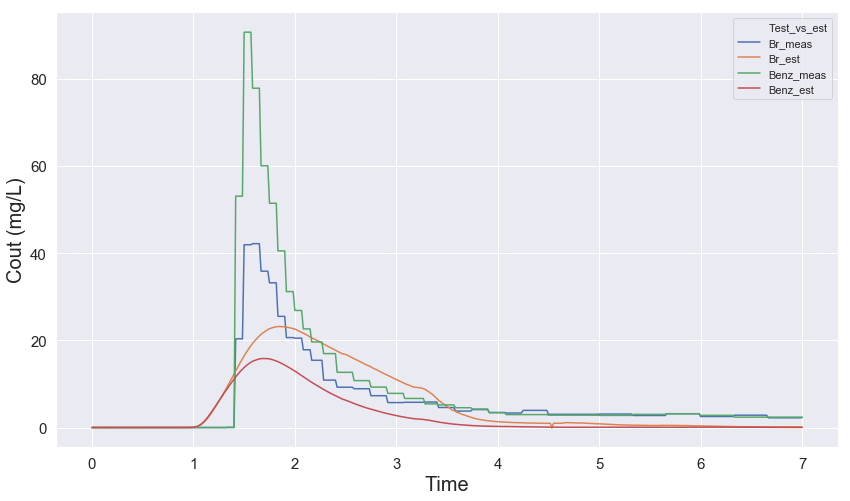

In [42]:
from BCBlues import BCBlues
outpath ='D:/OneDrive - University of Toronto/University/_Active Projects/Bioretention Blues Model/Model/Pickles/tracer_outs.pkl'
#outpath ='D:/OneDrive - University of Toronto/University/_Active Projects/Bioretention Blues Model/Model/Pickles/tracer_outs_BenzoAmazing.pkl'
res_time = pd.read_pickle(outpath)
#Now, let's see how benzotriazole is doing
#For this, we need to convert to concentration - C (g/m³)= M/Q*(molar mass)
kortright_bc = BCBlues(locsumm,chemsumm,params,timeseries,numc) #Load the model
mass_flux = kortright_bc.mass_flux(res_time,numc) #Run to get mass flux
numx = mass_flux.index.levels[2][-1]#Final cell
Couts = pd.DataFrame(timeseries.time,index = timeseries[timeseries.time>=0].index)
Couts.loc[:,'Q_out'] = np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])
Couts.loc[:,'Br_meas'] = timeseries[timeseries.time>=0].loc[:,'Bromide_Cout (measured)'] #g/m³
Couts.loc[:,'Benz_meas']=timeseries[timeseries.time>=0].loc[:,'Benzotriazole_Cout (measured)'] #g/m³
Couts.loc[:,'Br_est'] = np.array(mass_flux.loc[('Bromide',slice(None),numx),'N_effluent'])\
/np.array(res_time.loc[('Bromide',slice(None),numx),'Qout'])*np.array(chemsumm.MolMass.Bromide)
Couts.loc[:,'Benz_est'] = np.array(mass_flux.loc[('Benzotriazole',slice(None),numx),'N_effluent'])\
/np.array(res_time.loc[('Benzotriazole',slice(None),numx),'Qout'])*np.array(chemsumm.MolMass.Benzotriazole)
Couts[np.isnan(Couts)] = 0
Couts[np.isinf(Couts)] = 0 #if no flow, 0
pltdata = Couts[['time','Br_meas','Br_est','Benz_meas','Benz_est']]
pltdata = pltdata.melt('time',var_name = 'Test_vs_est',value_name = 'Cout (mg/L)')
ylim = [0, 50]
ylabel = 'Cout (mg/L)'
xlabel = 'Time'
#pltdata = res_time #All times at once
fig = plt.figure(figsize=(14,8))
ax = sns.lineplot(x = pltdata.time, y = 'Cout (mg/L)', hue = 'Test_vs_est',data = pltdata)
#ax.set_ylim(ylim)
ax.set_ylabel(ylabel, fontsize=20)
ax.set_xlabel(xlabel, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
KGE_Benz = hydroeval.evaluator(kge, np.array(Couts.loc[:,'Benz_est']),\
                      np.array(Couts.loc[:,'Benz_meas']))
KGE_Benz

In [41]:
chemsumm = pd.read_excel('Kortright_CHEMSUMM.xlsx',index_col = 0)